### Analysis  of finetuning time

In [1]:
# load important modules

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import math

#### Data preprocessing

In [2]:
# WNLI
wnli_uncased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/WNLI_uncased.csv", 
                   delimiter=',', decimal=',')
# RTE
rte_uncased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/RTE_uncased.csv", 
                   delimiter=',', decimal=',')
rte_cased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/RTE_cased.csv", 
                   delimiter=',', decimal=',')

# MRPC
mrpc_uncased = pd.read_excel("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/MRPC_uncased.xlsx", 
                   delimiter=',', decimal=',')
mrpc_cased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/MRPC_cased.csv", 
                   delimiter=',', decimal=',')

# CoLA
cola_uncased = pd.read_excel("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/CoLa_uncased.xlsx", 
                   delimiter=',', decimal=',')
cola_cased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/CoLa_cased.csv", 
                   delimiter=',', decimal=',')

# SST-B
stsb_all = pd.read_excel("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/STS-B_all.xlsx", 
                   delimiter=',', decimal=',')

# STS-2
sst2_all = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/finetuning time/SST-2_all.csv", 
                   delimiter=',', decimal=',')

# concatenate all datasets 
data = pd.concat([wnli_uncased, rte_uncased, rte_cased, mrpc_uncased, mrpc_cased, cola_uncased, 
                  cola_cased, stsb_all, sst2_all])

In [3]:
# only include important variables
data2 = data[['State', 'task_name', 'model_name_or_path', 'learning_rate', 'per_device_train_batch_size', 'max_seq_length', 
              'eval_steps', 'eval_acc', 'eval_loss', 'eval_corr', 'eval_f1', 'eval_mcc', 'eval_pearson', 'eval_spearmanr',
              'finetuning_time_list','finetuning_iters', 'loss', 'weight_decay']]
data2.index = range(0,len(data2))

print(data2.shape)
data2.sample(2)

(342, 18)


,State,task_name,model_name_or_path,learning_rate,per_device_train_batch_size,max_seq_length,eval_steps,eval_acc,eval_loss,eval_corr,eval_f1,eval_mcc,eval_pearson,eval_spearmanr,finetuning_time_list,finetuning_iters,loss,weight_decay
193,finished,CoLA,bert-base-uncased,1e-05,16,256,1000.0,NaN,0.467358,NaN,NaN,0.477654,NaN,NaN,"[2543.8515617847443,2592.991079568863,2477.751...",3,0.188806,0.01
74,finished,RTE,bert-base-uncased,0.00005,8,256,1000.0,0.6787003610108303,0.6243820326668875,NaN,NaN,NaN,NaN,NaN,"[798.7048346996307,805.5616698265076,765.59285...",5,0.4813197720050812,0.01


In [4]:
# add column with number of observations
data2.loc[(data2.task_name == 'WNLI'), 'num_examples'] = 635
data2.loc[(data2.task_name == 'RTE'), 'num_examples'] = 2490
data2.loc[(data2.task_name == 'MRPC'), 'num_examples'] = 3668
data2.loc[(data2.task_name == 'STS-B'), 'num_examples'] = 5749
data2.loc[(data2.task_name == 'CoLA'), 'num_examples'] = 8550
data2.loc[(data2.task_name == 'SST-2'), 'num_examples'] = 67349

C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
# there are some runs in the dataset that failed/crashed --> only include finished runs
data3 = data2.loc[data2.State == 'finished']

data3.shape[0] # number of examples

291

In [6]:
# Describe respective variables 
data3.describe()

,per_device_train_batch_size,max_seq_length,eval_steps,eval_corr,eval_pearson,eval_spearmanr,finetuning_iters,num_examples
count,291.000000,291.000000,291.0,45.000000,45.000000,45.000000,291.000000,291.000000
mean,18.666667,300.865979,1000.0,0.867349,0.868051,0.866646,4.092784,11393.247423
std,9.994941,160.550323,0.0,0.019566,0.019871,0.019345,0.997402,20209.290545
min,8.000000,128.000000,1000.0,0.829953,0.827459,0.830657,3.000000,635.000000
25%,8.000000,128.000000,1000.0,0.851157,0.851222,0.850218,3.000000,2490.000000
50%,16.000000,256.000000,1000.0,0.874486,0.871842,0.877062,5.000000,3668.000000
75%,32.000000,512.000000,1000.0,0.884482,0.886117,0.882848,5.000000,8550.000000
max,32.000000,512.000000,1000.0,0.893516,0.892947,0.894086,5.000000,67349.000000


In [7]:
# Regard info of several features (need to change the type of some variables)
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 0 to 341
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   State                        291 non-null    object 
 1   task_name                    291 non-null    object 
 2   model_name_or_path           291 non-null    object 
 3   learning_rate                291 non-null    object 
 4   per_device_train_batch_size  291 non-null    int64  
 5   max_seq_length               291 non-null    int64  
 6   eval_steps                   291 non-null    float64
 7   eval_acc                     192 non-null    object 
 8   eval_loss                    291 non-null    object 
 9   eval_corr                    45 non-null     float64
 10  eval_f1                      51 non-null     object 
 11  eval_mcc                     54 non-null     object 
 12  eval_pearson                 45 non-null     float64
 13  eval_spearmanr      

In [8]:
# change the format of the finetuning list in order to ba able to work with it
def timelist_transform(data = data3.finetuning_time_list):
    
    # save transformed results in defaultdict
    time_dict = defaultdict(list)
    counter = 0
    
    for row in data:
        time_list = []
        for i in row.strip('][').split(','):
            time_list.append(float(i))
        time_dict[data3.index[counter]] = time_list
        counter += 1
        
    return time_dict

In [9]:
# add transformed lists to dataframe
finetuning_dict = timelist_transform(data3.finetuning_time_list)
data3.loc[:,'finetuning_time_list'] = data3.index.map(finetuning_dict)

C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# check if type conversion succeeded
print(type(data3.finetuning_time_list[9])) # list
print(type(data3.finetuning_time_list[9][1])) #float
data3.finetuning_time_list.sample(2)

<class 'list'>
<class 'float'>


258    [1389.448937416077, 1372.4952232837677, 1360.5...
315    [8003.73255610466, 7846.35068321228, 7813.9086...
Name: finetuning_time_list, dtype: object

In [11]:
# change variable types
data3.loc[:,'model_name_or_path'] = data3.loc[:,'model_name_or_path'].astype('category')
data3.loc[:,'task_name'] = data3.loc[:,'task_name'].astype('category')
data3.loc[:,'learning_rate'] = data3.loc[:,'learning_rate'].astype('float64')
data3.loc[:,'eval_acc'] = data3.loc[:,'eval_acc'].astype('float64')
data3.loc[:,'eval_loss'] = data3.loc[:,'eval_loss'].astype('float64')
data3.loc[:,'num_examples'] = data3.loc[:,'num_examples'].astype('int64')

In [12]:
# calculate minimal finetuning_time
data3['finetuning_time'] = data3.loc[:,'finetuning_time_list'].apply(lambda x: min(x))

<ipython-input-12-faadc63ac68c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['finetuning_time'] = data3.loc[:,'finetuning_time_list'].apply(lambda x: min(x))


In [33]:
# learning rate value of MRPC was not recognized properly -> added manually
data3.loc[(data3.task_name == 'MRPC'), 'learning_rate'] = 3e-5

C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Descriptive analysis

In [21]:
# print maximum finetuning time
print('Maximal finetuning time')
print(' ')
print(data3.loc[data3.finetuning_time.idxmax(axis=0),:])

# minimal finetuning time
print(' ')
print('Minimal finetuning time')
print(' ')
print(data3.loc[data3.finetuning_time.idxmin(axis=0),:])

Maximal finetuning time
 
State                                                                   finished
task_name                                                                  SST-2
model_name_or_path                                             bert-base-uncased
learning_rate                                                              1e-05
per_device_train_batch_size                                                   32
max_seq_length                                                               512
eval_steps                                                                  1000
eval_acc                                                                0.917431
eval_loss                                                               0.220054
eval_corr                                                                    NaN
eval_f1                                                                      NaN
eval_mcc                                                                     NaN
ev

In [22]:
data3.head()

,State,task_name,model_name_or_path,learning_rate,per_device_train_batch_size,max_seq_length,eval_steps,eval_acc,eval_loss,eval_corr,eval_f1,eval_mcc,eval_pearson,eval_spearmanr,finetuning_time_list,finetuning_iters,loss,weight_decay,num_examples,finetuning_time
0,finished,WNLI,xlnet-base-cased,0.00002,32,512,1000.0,0.492958,0.707652,NaN,NaN,NaN,NaN,NaN,"[1511.446849346161, 1453.9288070201874, 1480.7...",5,0.28129574060440066,0.01,635,1453.928807
1,finished,WNLI,xlnet-base-cased,0.00002,16,512,1000.0,0.507042,0.707963,NaN,NaN,NaN,NaN,NaN,"[1437.6936128139496, 1419.2357952594757, 1443....",5,0.5560731422901154,0.01,635,1419.235795
2,finished,WNLI,xlnet-base-cased,0.00002,8,512,1000.0,0.563380,0.704241,NaN,NaN,NaN,NaN,NaN,"[1697.3308124542236, 1648.7515692710876, 1653....",5,0.726203420162201,0.01,635,1648.751569
3,finished,WNLI,albert-base-v1,0.00002,32,512,1000.0,0.422535,0.706421,NaN,NaN,NaN,NaN,NaN,"[525.2835969924927, 575.5731990337372, 594.096...",5,0.27751596450805666,0.01,635,525.283597
4,finished,WNLI,albert-base-v1,0.00002,16,512,1000.0,0.464789,0.702587,NaN,NaN,NaN,NaN,NaN,"[363.27685737609863, 343.1901717185974, 347.72...",5,0.5606631636619568,0.01,635,343.190172


In [23]:
# describe fine-tuning time
data3.finetuning_time.describe()

count      291.000000
mean      3670.464459
std       7650.926723
min         40.286524
25%        508.681280
50%       1195.345378
75%       2802.766183
max      59139.089465
Name: finetuning_time, dtype: float64

In [24]:
# regard statistical key values, such as median, etc of fine-tuning time
median = data3.finetuning_time.median()
upper_quartile = data3.finetuning_time.quantile(0.75)
lower_quartile = data3.finetuning_time.quantile(0.25)
maximum = data3.finetuning_time.max()

iqr = upper_quartile - lower_quartile
upper_whisker = data3.finetuning_time[data3.finetuning_time<=upper_quartile+1.5*iqr].max()
lower_whisker = data3.finetuning_time[data3.finetuning_time>=lower_quartile-1.5*iqr].min()

In [25]:
print("Minimum: ", data3.finetuning_time.min())
print("Lower whisker: ", lower_whisker)
print("Median: ", median)
print("Upper whisker: ", upper_whisker)
print("Maximum: ", maximum)

Minimum:  40.28652381896973
Lower whisker:  40.28652381896973
Median:  1195.345378160477
Upper whisker:  5848.839823246002
Maximum:  59139.08946490288


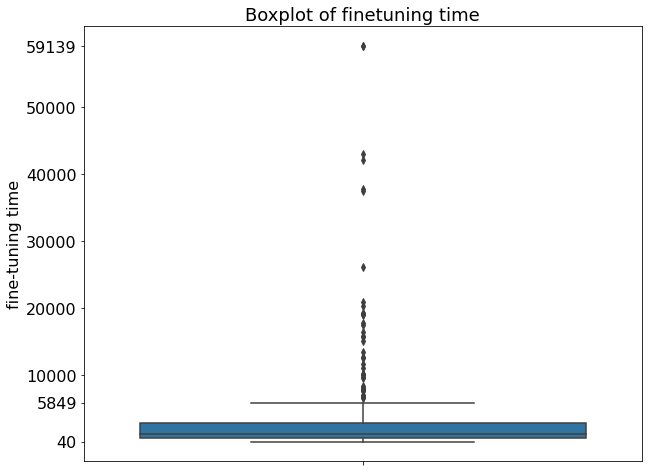

In [26]:
# Boxplots for fine-tuning time, gouped by learning rate

plt.figure(figsize = (10, 8))
ax = sns.boxplot(y = 'finetuning_time', data = data3)
ax.set_yticks([lower_whisker, upper_whisker, 10000, 20000, 30000, 40000, 50000, maximum])
plt.ylabel('fine-tuning time', fontsize = 16)
plt.title('Boxplot of finetuning time', fontsize = 18)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('finetuning_time_boxplot.png')

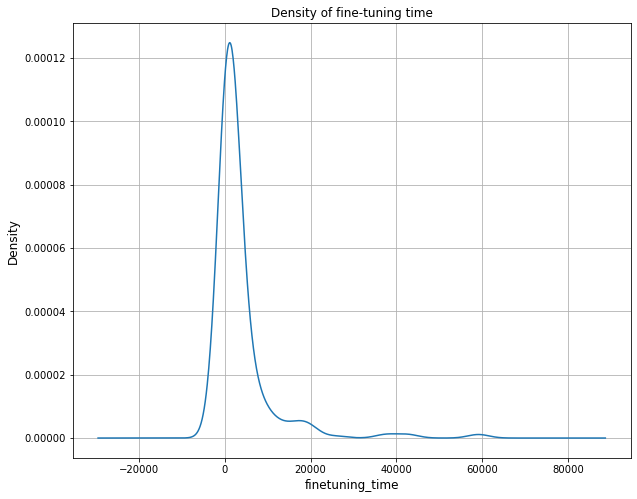

In [27]:
# Plot density of fine-tuning time 

plt.figure(figsize = (10, 8))
data3.finetuning_time.plot(kind = 'kde', grid = True,linestyle = '-')
plt.xlabel('finetuning_time', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.title('Density of fine-tuning time', fontsize = 12)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=12)
plt.show()

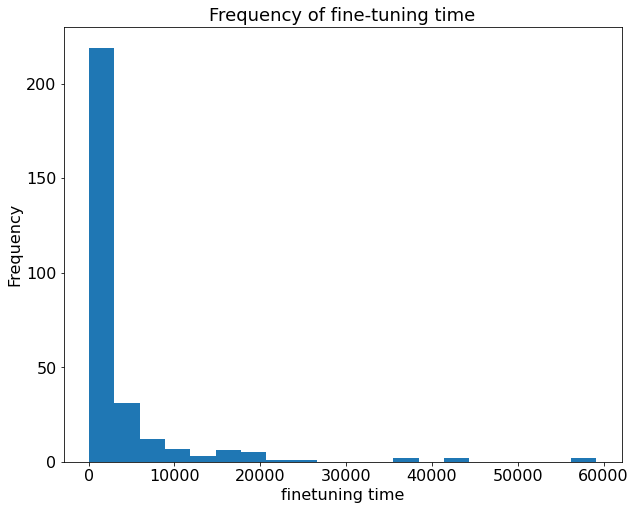

In [28]:
# Histogram fine-tuning time

plt.figure(figsize = (10, 8))
ax = data3.finetuning_time.plot(kind = 'hist', bins = 20)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000, 60000])
plt.xlabel('finetuning time', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Frequency of fine-tuning time', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('finetuning_time_hist.png')

In [29]:
counts, bin_edges = np.histogram(data3.finetuning_time, bins=20)
print(counts)
print(bin_edges)

[219  31  12   7   3   6   5   1   1   0   0   0   2   0   2   0   0   0
   0   2]
[4.02865238e+01 2.99522667e+03 5.95016682e+03 8.90510696e+03
 1.18600471e+04 1.48149873e+04 1.77699274e+04 2.07248676e+04
 2.36798077e+04 2.66347478e+04 2.95896880e+04 3.25446281e+04
 3.54995683e+04 3.84545084e+04 4.14094486e+04 4.43643887e+04
 4.73193289e+04 5.02742690e+04 5.32292092e+04 5.61841493e+04
 5.91390895e+04]


#### Plot correlations

In [32]:
# Correlation matrix
data_sub = data3[["per_device_train_batch_size", "max_seq_length", "num_examples", "finetuning_time"]] 
                    # "eval_acc", "eval_loss", "learning_rate",
data_sub.corr()

,per_device_train_batch_size,max_seq_length,num_examples,finetuning_time
per_device_train_batch_size,1.000000e+00,-2.638424e-17,-7.949518e-18,0.011134
max_seq_length,-2.638424e-17,1.000000e+00,-4.856864e-02,0.261017
num_examples,-7.949518e-18,-4.856864e-02,1.000000e+00,0.732855
finetuning_time,1.113437e-02,2.610169e-01,7.328552e-01,1.000000


In [55]:
data_sub.columns

Index(['per_device_train_batch_size', 'max_seq_length', 'num_examples',
       'finetuning_time'],
      dtype='object')

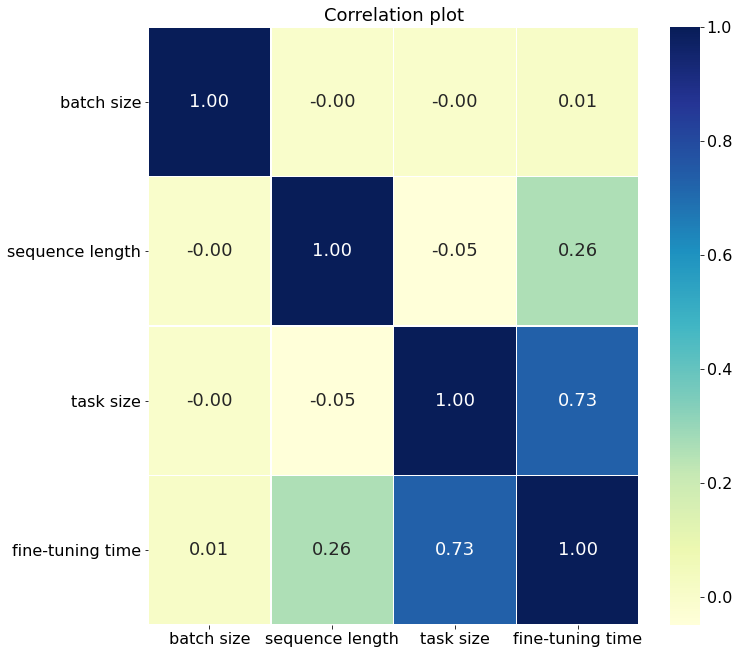

In [56]:
# correlation matrix plot
plt.rcParams['font.size'] = 16
plt.figure(figsize=(11,11))
ht = sns.heatmap(data_sub.corr(), annot=True, linewidths=.5, fmt= '.2f', cmap="YlGnBu", annot_kws={'size':18})
plt.xticks(np.arange(len(data_sub.columns))+0.5, labels = ['batch size', 'sequence length', 'task size', 'fine-tuning time'], 
           fontsize = 16, rotation='horizontal')
plt.yticks(np.arange(len(data_sub.columns))+0.5, labels = ['batch size', 'sequence length', 'task size', 'fine-tuning time'], 
           fontsize = 16)
plt.title('Correlation plot', fontsize = 18)
plt.show()
ht.figure.savefig('finetuning_correlation_plot.png', bbox_inches='tight')

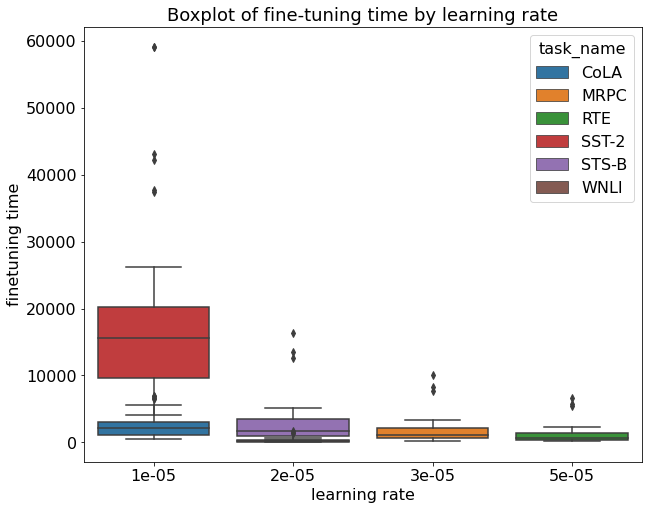

In [57]:
# Boxplots for fine-tuning time, gouped by learning rate

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'learning_rate', y = 'finetuning_time', hue = 'task_name', data = data3, dodge = False)
plt.ylabel('finetuning time', fontsize = 16)
plt.xlabel('learning rate', fontsize = 16)
plt.title('Boxplot of fine-tuning time by learning rate', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
#ax.figure.savefig('finetuning_time_hist.png')

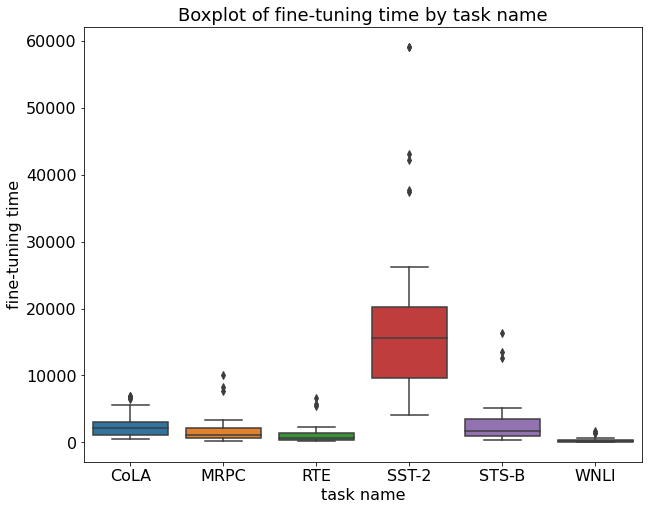

In [58]:
# Boxplots for fine-tuning time, gouped by task_name

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'task_name', y = 'finetuning_time', data = data3)
plt.ylabel('fine-tuning time', fontsize = 16)
plt.xlabel('task name', fontsize = 16)
plt.title('Boxplot of fine-tuning time by task name', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('finetuning_time_task.png')

In [59]:
data3.groupby('task_name').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
task_name,,,,,,,,
CoLA,54.0,2555.160422,1858.062815,523.532929,1144.698240,2100.402163,3082.478353,6988.001138
MRPC,51.0,1764.874162,1970.488601,229.857931,642.096134,1050.338825,2193.667961,10063.199610
RTE,63.0,1062.062172,1247.668389,154.806281,367.913215,636.692311,1400.431524,6667.964992
SST-2,33.0,19175.277571,14623.082097,4017.149742,9599.713058,15637.086031,20238.673438,59139.089465
STS-B,45.0,2812.326184,3362.888811,368.410827,931.664032,1655.719302,3538.610994,16341.794860
WNLI,45.0,308.203499,359.025950,40.286524,102.659339,179.500145,392.959456,1648.751569


In [60]:
data3[data3.model_name_or_path != 'xlnet-base-cased'].groupby('task_name').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
task_name,,,,,,,,
CoLA,54.0,2555.160422,1858.062815,523.532929,1144.698240,2100.402163,3082.478353,6988.001138
MRPC,42.0,1258.801212,867.453451,229.857931,549.726374,998.022020,2055.596293,3387.689235
RTE,54.0,765.297633,573.804412,154.806281,354.879209,597.763485,920.093928,2280.374817
SST-2,33.0,19175.277571,14623.082097,4017.149742,9599.713058,15637.086031,20238.673438,59139.089465
STS-B,36.0,1826.584819,1286.466172,368.410827,839.701883,1422.468729,2502.439291,5132.771498
WNLI,36.0,204.458432,151.469859,40.286524,91.640265,154.513943,275.554493,589.084243


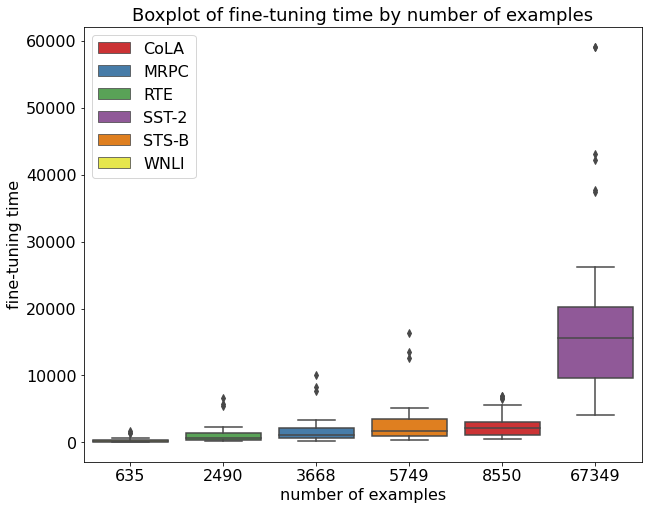

In [61]:
# Boxplots for fine-tuning time, gouped by number pf examples

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'num_examples', y = 'finetuning_time', data = data3, hue = 'task_name', dodge=False, 
                 palette = sns.color_palette('Set1'))
plt.legend(loc='upper left')
plt.ylabel('fine-tuning time', fontsize = 16)
plt.xlabel('number of examples', fontsize = 16)
plt.title('Boxplot of fine-tuning time by number of examples', fontsize = 18) 
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('finetuning_time_number.png')

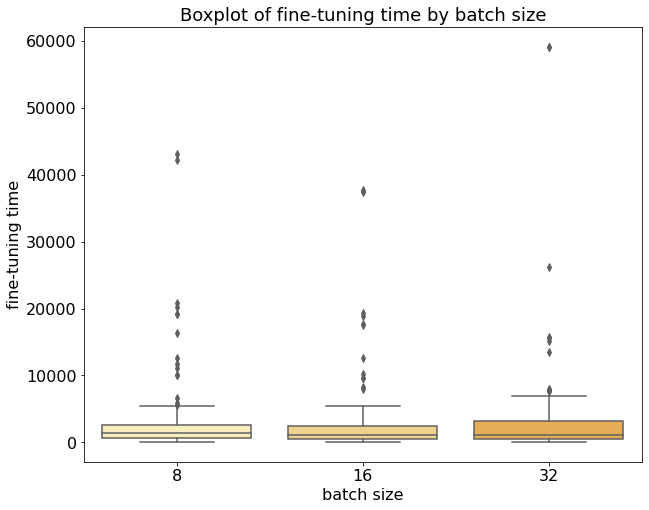

In [33]:
# Boxplots for fine-tuning time, grouped by batch size

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'per_device_train_batch_size', y = 'finetuning_time', data = data3, palette = sns.color_palette('YlOrBr'))
plt.ylabel('fine-tuning time', fontsize = 16)
plt.xlabel('batch size', fontsize = 16)
plt.title('Boxplot of fine-tuning time by batch size', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('finetuning_time_batch_size.png')

In [34]:
data3.groupby('per_device_train_batch_size').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
per_device_train_batch_size,,,,,,,,
8,97.0,3784.033027,7286.163882,64.281345,605.507078,1318.680864,2581.861437,43090.039219
16,97.0,3341.013022,6447.097114,47.965026,493.829632,1135.566654,2477.751551,37749.208026
32,97.0,3886.347327,9055.744924,40.286524,461.683720,1033.939928,3179.976545,59139.089465


In [41]:
# for a fair comparison, exclude SST-2 and MRPC (because albert crashed for seq len = 512 and MRPC failed
# for bert-cased und distilbert-cased with 128 and 256)
data3[(data3.task_name != 'MRPC') & 
      (data3.task_name != 'SST-2')].groupby('per_device_train_batch_size').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
per_device_train_batch_size,,,,,,,,
8,69.0,1738.413097,2338.832905,64.281345,409.567721,1119.747446,1786.740488,16341.794860
16,69.0,1526.286199,1937.406274,47.965026,370.360437,847.892424,1667.434809,12545.816008
32,69.0,1739.828463,2304.825883,40.286524,324.649789,952.751559,2076.652052,13471.597539


In [40]:
# have a look at fine-tuning time grouped by maximum sequence length and batch size (w/o MRPC and SST-2)
data3[(data3.task_name != 'MRPC') & 
      (data3.task_name != 'SST-2')].groupby(['max_seq_length', 'per_device_train_batch_size']).finetuning_time.describe()

count         mean          std  \
max_seq_length per_device_train_batch_size                                    
128            8                            23.0   738.865493   547.447761    
               16                           23.0   563.207616   411.543627    
               32                           23.0   536.486247   454.408521    
256            8                            23.0   1256.955835  1002.262373   
               16                           23.0   1269.804995  1151.505883   
               32                           23.0   1095.391246  1018.183618   
512            8                            23.0   3219.417965  3467.499662   
               16                           23.0   2745.845985  2741.011044   
               32                           23.0   3587.607895  3107.876908   

                                                   min          25%  \
max_seq_length per_device_train_batch_size                            
128            8                            64.281345   253.879957    
               16                           47.965026   194.265080    
               32                           40.286524   191.540546    
256            8                            102.304002  420.980400    
               16                           90.233817   464.760164    
               32                           73.739370   372.959155    
512            8                            203.470000  1178.910309   
               16                           169.152534  1008.406205   
               32                           253.009267  1223.499772   

                                                    50%          75%  \
max_seq_length per_device_train_batch_size                             
128            8                            613.991491   1157.557138   
               16                           431.713296   879.104954    
               32                           368.410827   740.438399    
256            8                            1000.772385  1722.855572   
               16                           815.130262   1895.693114   
               32                           665.150294   1669.519499   
512            8                            1916.330025  4468.258628   
               16                           1542.900919  4058.184060   
               32                           2285.639877  5427.713994   

                                                     max  
max_seq_length per_device_train_batch_size                
128            8                            1786.740488   
               16                           1263.127977   
               32                           1942.087265   
256            8                            3908.210365   
               16                           5027.712478   
               32                           4523.116153   
512            8                            16341.794860  
               16                           12545.816008  
               32                           13471.597539

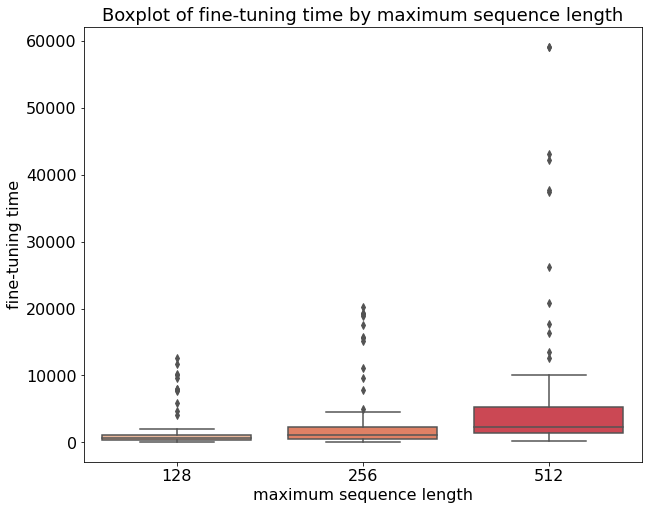

In [37]:
# Boxplots for fine-tuning time, gouped by max sequence length

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'max_seq_length', y = 'finetuning_time', data = data3, palette = sns.color_palette('rocket_r'))
plt.xlabel('maximum sequence length', fontsize = 16)
plt.ylabel('fine-tuning time', fontsize = 16)
plt.title('Boxplot of fine-tuning time by maximum sequence length', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('finetuning_time_seq_length.png')

In [38]:
data3.groupby('max_seq_length').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
max_seq_length,,,,,,,,
128,96.0,1572.247147,2754.049584,40.286524,304.245083,597.625219,1102.268287,12611.020743
256,96.0,3034.404364,5130.206896,73.739370,561.979796,1133.516020,2333.340849,20238.673438
512,99.0,6321.884974,11337.728899,169.152534,1366.014475,2314.634986,5318.496162,59139.089465


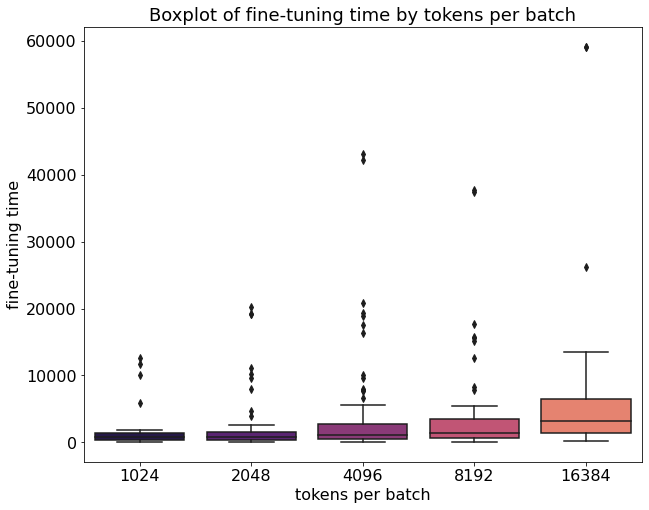

In [39]:
# Boxplots for fine-tuning time, gouped by tokens per batch

# add tokens per batch to dataset
data3.loc[:,'tokens_per_batch'] = data3.apply(lambda row: (row['per_device_train_batch_size']*row['max_seq_length']), axis=1)

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'tokens_per_batch', y = 'finetuning_time', data = data3, palette = sns.color_palette('magma'))
plt.ylabel('fine-tuning time', fontsize = 16)
plt.xlabel('tokens per batch', fontsize = 16)
plt.title('Boxplot of fine-tuning time by tokens per batch', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('finetuning_time_tokensperbatch.png')

In [40]:
data3.groupby('tokens_per_batch').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
tokens_per_batch,,,,,,,,
1024,32.0,1896.557662,3301.528223,64.281345,405.658132,756.602975,1366.075103,12611.020743
2048,64.0,2386.760667,4477.477111,47.965026,395.288926,794.601026,1592.432712,20238.673438
4096,97.0,3558.849864,7136.960276,40.286524,453.579524,1071.686663,2685.961267,43090.039219
8192,65.0,3998.779063,7259.420583,73.739370,653.791794,1437.023063,3410.899668,37749.208026
16384,33.0,7561.622839,14139.999589,253.009267,1453.928807,3164.878497,6485.429604,59139.089465


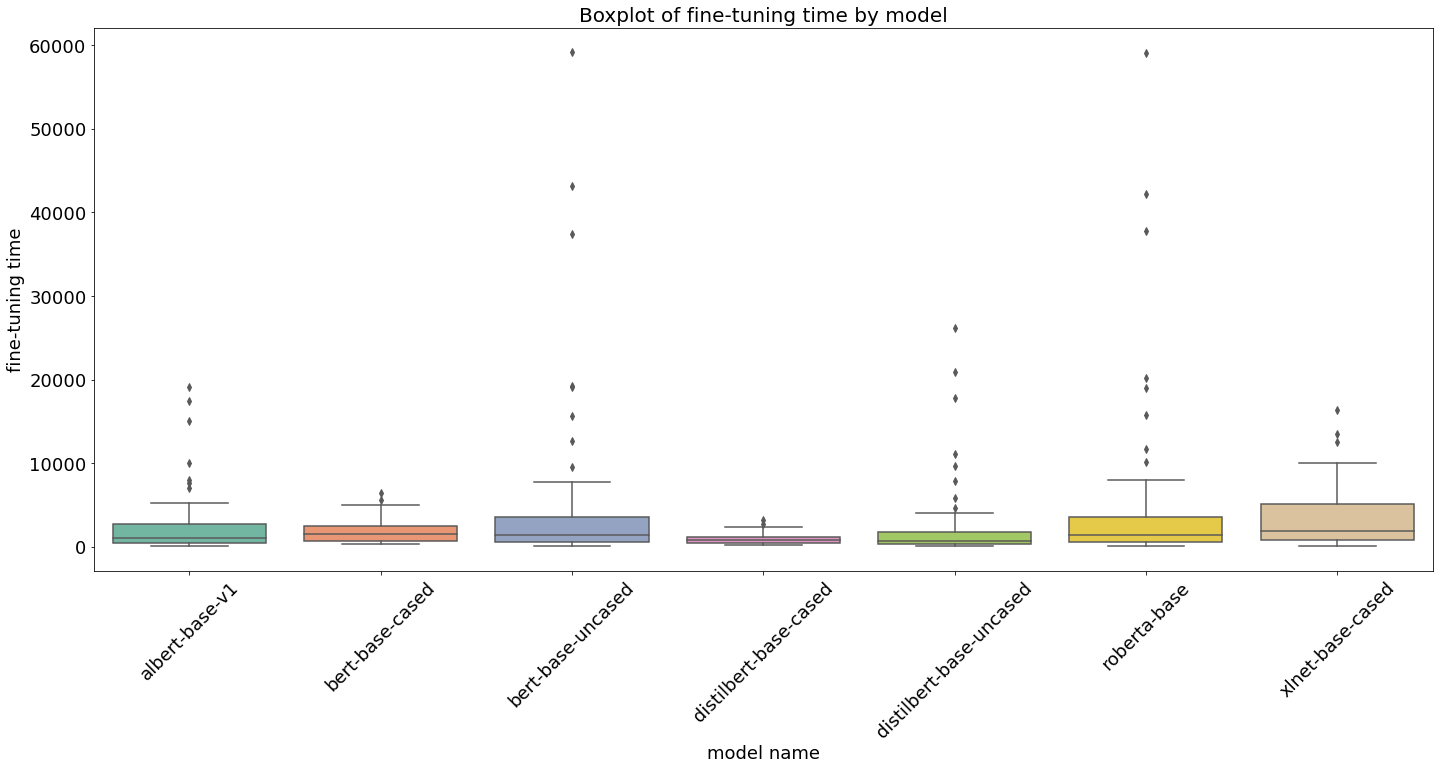

In [41]:
# Boxplots for fine-tuning time, gouped by model 

plt.figure(figsize = (24, 10))
ax = sns.boxplot(x = 'model_name_or_path', y = 'finetuning_time', data = data3, palette = sns.color_palette("Set2"))
plt.ylabel('fine-tuning time', fontsize = 18)
plt.xlabel('model name', fontsize = 18)
plt.title('Boxplot of fine-tuning time by model', fontsize = 20)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=18)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=18)
plt.show()
ax.figure.savefig('finetuning_time_models.png', bbox_inches='tight')

In [43]:
data3.groupby('model_name_or_path').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
model_name_or_path,,,,,,,,
albert-base-v1,51.0,2801.667096,4291.786384,75.501637,501.544123,1096.441900,2782.319082,19153.571484
bert-base-cased,21.0,2116.260848,1718.908362,323.242815,744.541753,1567.902107,2490.166188,6485.429604
bert-base-uncased,54.0,5448.909548,11216.587055,79.490505,566.110434,1388.864147,3596.261203,59139.089465
distilbert-base-cased,21.0,1003.987066,810.388556,154.806281,445.314242,817.478578,1195.345378,3164.878497
distilbert-base-uncased,54.0,2633.088138,5248.098842,40.286524,283.258810,659.471044,1822.972749,26147.164209
roberta-base,54.0,5430.333326,11186.496445,79.554176,593.083385,1410.363709,3618.054065,59108.727824
xlnet-base-cased,36.0,3611.918187,4097.207193,147.439662,813.428770,1848.710774,5117.679508,16341.794860


In [44]:
# for a fair comparison of albert-base-v1, bert-base-uncase, distilbert-base-uncased, roberta-based and xlnet-base-cased
data3[(data3.task_name != 'SST-2') & (data3.task_name != 'CoLA')].groupby('model_name_or_path').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
model_name_or_path,,,,,,,,
albert-base-v1,36.0,1075.275297,1070.577960,75.501637,367.505944,627.153322,1434.964555,4442.835321
bert-base-cased,12.0,1374.347986,983.411587,323.242815,588.115497,1106.335517,2171.477857,3387.689235
bert-base-uncased,36.0,1179.372929,1164.524809,79.490505,392.293464,733.114647,1588.101322,5132.771498
distilbert-base-cased,12.0,626.629744,387.688118,154.806281,286.128951,556.901028,963.545499,1219.951793
distilbert-base-uncased,36.0,572.284356,532.335330,40.286524,201.344868,392.042302,810.511111,2285.639877
roberta-base,36.0,1153.665956,1045.488240,79.554176,404.979798,780.359628,1611.469272,4056.350114
xlnet-base-cased,36.0,3611.918187,4097.207193,147.439662,813.428770,1848.710774,5117.679508,16341.794860


In [45]:
# for a fair comparison of models (especially considering cased versions)
data3[(data3.task_name == 'CoLA') | (data3.task_name == 'RTE')].groupby('model_name_or_path').finetuning_time.describe()

,count,mean,std,min,25%,50%,75%,max
model_name_or_path,,,,,,,,
albert-base-v1,18.0,1909.441578,1879.558587,281.549841,570.139381,1333.502730,2121.668384,6988.001138
bert-base-cased,18.0,2032.219288,1835.907131,323.242815,737.836038,1491.652815,2437.718345,6485.429604
bert-base-uncased,18.0,2021.613583,1882.954403,311.810163,668.917447,1462.708257,2406.047478,6851.452623
distilbert-base-cased,18.0,984.625470,876.536279,154.806281,389.148531,732.419346,1138.613173,3164.878497
distilbert-base-uncased,18.0,990.582898,901.430203,166.221296,354.879209,714.199761,1158.236192,3179.976545
roberta-base,18.0,2022.891348,1843.994073,324.649789,726.806673,1490.211808,2374.519669,6664.232317
xlnet-base-cased,9.0,2842.649404,2392.003695,600.458358,824.491574,1910.681060,5387.580599,6667.964992


In [35]:
# Overview over fine-tuning time, grouped by every regarded hyperparameter

table = data3.groupby(['model_name_or_path', 'num_examples', 'max_seq_length', 
                       'per_device_train_batch_size']).finetuning_time.median()
table.to_excel("finetuning_time_table.xlsx")

#### ANOVA #####

In [45]:
#!pip install statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
import statsmodels.api as sm

# seq_length_log als kat. Variable für ANOVA
data3['seq_len_cat'] = data3.loc[:,'max_seq_length'].astype('category')
mod_len = ols('finetuning_time ~ seq_len_cat', data=data3).fit()
# seq_length_log als kat. Variable für ANOVA
data3['batch_size_cat'] = data3.loc[:,'per_device_train_batch_size'].astype('category')
mod_bs = ols('finetuning_time ~ batch_size_cat', data=data3).fit()
mod_type = ols('finetuning_time ~ model_name_or_path', data=data3).fit()
mod_task = ols('finetuning_time ~ task_name', data=data3).fit()

models = [mod_len, mod_bs, mod_type, mod_task]

for m in models:
    aov_table = sm.stats.anova_lm(m, typ=2)
    print(aov_table)

                   sum_sq     df          F    PR(>F)
seq_len_cat  1.157454e+09    2.0  10.536817  0.000038
Residual     1.581818e+10  288.0        NaN       NaN
                      sum_sq     df         F    PR(>F)
batch_size_cat  1.630002e+07    2.0  0.138402  0.870807
Residual        1.695934e+10  288.0       NaN       NaN
                          sum_sq     df         F    PR(>F)
model_name_or_path  6.348097e+08    6.0  1.838809  0.091525
Residual            1.634083e+10  284.0       NaN       NaN
                 sum_sq     df          F        PR(>F)
task_name  9.156031e+09    5.0  66.741701  5.534676e-46
Residual   7.819606e+09  285.0        NaN           NaN


<ipython-input-45-03d9e557e219>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['seq_len_cat'] = data3.loc[:,'max_seq_length'].astype('category')
<ipython-input-45-03d9e557e219>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['batch_size_cat'] = data3.loc[:,'per_device_train_batch_size'].astype('category')


In [46]:
## Tukey's range test 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# maximum sequence length
res_sq_len = pairwise_tukeyhsd(data3['finetuning_time'], data3['seq_len_cat'])
print('Pairwise Tukeys range test w.r.t. maximum sequence length')
print(res_sq_len)

# batch size
res_bs = pairwise_tukeyhsd(data3['finetuning_time'], data3['batch_size_cat'])
print('Pairwise Tukeys range test w.r.t. batch size')
print(res_bs)

# model 
res_model = pairwise_tukeyhsd(data3['finetuning_time'], data3['model_name_or_path'])
print('Pairwise Tukeys range test w.r.t. model')
print(res_model)

# task
res_task = pairwise_tukeyhsd(data3['finetuning_time'], data3['task_name'])
print('Pairwise Tukeys range test w.r.t. task')
print(res_task)

Pairwise Tukeys range test w.r.t. maximum sequence length
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
   128    256 1462.1572 0.3607 -1058.0767 3982.3911  False
   128    512 4749.6378  0.001  2248.5695 7250.7062   True
   256    512 3287.4806 0.0061   786.4122  5788.549   True
----------------------------------------------------------
Pairwise Tukeys range test w.r.t. batch size
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2 meandiff p-adj    lower      upper   reject
---------------------------------------------------------
     8     16  -443.02    0.9  -3039.092  2153.052  False
     8     32 102.3143    0.9 -2493.7577 2698.3863  False
    16     32 545.3343 0.8611 -2050.7377 3141.4063  False
---------------------------------------------------------
Pairwise Tukeys range test w.r.t. model
                      Multiple Compari

#### Test ANOVA assumptions (not necessarily needed for my analysis because the ANOVA is just an ad-on)

In [47]:
# Shapiro-Wilk test: check normal distribution of residuals; H0: data is drawn from normal distribution

#import scipy.stats as stats

for m in models:
    w, pvalue = stats.shapiro(m.resid)
    print(w, pvalue)

# As the P-values are significant, we reject null hypothesis and conclude that data is not drawn from normal distribution

0.53741455078125 5.27663166156705e-27
0.4649805426597595 1.258119754702038e-28
0.5473810434341431 9.140948850407807e-27
0.5569232106208801 1.5608443470789738e-26


In [48]:
# Bartlett’s test to check the Homogeneity of variances. H0: samples from populations have equal variances.
# not possible to perform this test for categorical variables (task_name and model_name_or_path)

w, pvalue = stats.bartlett(data3['max_seq_length'], data3['per_device_train_batch_size'])
print(w, pvalue)
# p-value very low --> Reject H0 (no equal variances)

1208.5209151186648 8.579698089072475e-265


#### Linear regression model ####
Reference categories: 
- task: RTE
- model: bert-base-uncased

In [49]:
from statsmodels.regression import linear_model
import patsy
from patsy.contrasts import Treatment

In [37]:
# linear regression model (w/o transformation of variables)

y, X = patsy.dmatrices('finetuning_time ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_train_batch_size + max_seq_length', 
                       data3)

# linear regression model
model = linear_model.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        finetuning_time   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     41.19
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           4.61e-57
Time:                        16:01:28   Log-Likelihood:                -2858.1
No. Observations:                 291   AIC:                             5744.
Df Residuals:                     277   BIC:                             5796.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  -2479.2257   1093.158     -2.268      0.024   -4631.177    -327.274
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]          -1581.7411    893.841     -1.770      0.078   -3341.325     177.843
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]         -1103.8545   1223.042     -0.903      0.368   -3511.492    1303.783
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]   -2216.1283   1223.042     -1.812      0.071   -4623.766     191.509
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased] -2815.8214    879.696     -3.201      0.002   -4547.561   -1084.082
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]              -18.5762    879.696     -0.021      0.983   -1750.315    1713.163
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]         1527.9566   1005.060      1.520      0.130    -450.569    3506.483
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                            1895.5711    856.552      2.213      0.028     209.394    3581.749
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                             162.1582    873.985      0.186      0.853   -1558.338    1882.655
C(task_name, Treatment(reference="RTE"))[T.SST-2]                                           1.856e+04   1023.114     18.145      0.000    1.66e+04    2.06e+04
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                           1441.0197    923.713      1.560      0.120    -377.370    3259.409
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                           -1063.1029    923.713     -1.151      0.251   -2881.492     755.287
per_device_train_batch_size                                                                    8.5231     26.856      0.317      0.751     -44.344      61.390
max_seq_length                                                                                14.2938      1.682      8.496      0.000      10.982      17.606
==============================================================================
Omnibus:                      281.773   Durbin-Watson:                   0.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10540.132
Skew:                           3.852   Prob(JB):                         0.00
Kurtosis:                      31.460   Cond. No.               

In [59]:
# distribution of fine-tuning time is right skewed --> Take the log of the fine-tuning time
data3['finetuning_time_log'] = data3.finetuning_time.apply(lambda x: math.log(x))
data3.finetuning_time_log.describe()

<ipython-input-59-266c9dfb7fea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['finetuning_time_log'] = data3.finetuning_time.apply(lambda x: math.log(x))


count    291.000000
mean       7.145580
std        1.419689
min        3.696017
25%        6.231395
50%        7.086190
75%        7.938295
max       10.987647
Name: finetuning_time_log, dtype: float64

In [39]:
# log-linear regression model with logarithmized fine-tuning time

y, X = patsy.dmatrices('finetuning_time_log ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_train_batch_size + max_seq_length', 
                       data3)

# linear regression model
model = linear_model.OLS(y, X).fit()
model.summary()

# Jarque-Bera Test: H0 (residuals follow a normal distributio) is rejected
# Durbin-Watson test: d = 1.82 (within the range of 1.5 and 2.5 --> autocorrelation should not be problematic)

# R^2 of log-linear regression model is higher (0.984) than the one of the linear regression model (0.659)
# --> Use log-linear regression model 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     finetuning_time_log   R-squared:                       0.984
Model:                             OLS   Adj. R-squared:                  0.983
Method:                  Least Squares   F-statistic:                     1274.
Date:                 Thu, 05 Nov 2020   Prob (F-statistic):          1.78e-238
Time:                         16:01:36   Log-Likelihood:                 83.297
No. Observations:                  291   AIC:                            -138.6
Df Residuals:                      277   BIC:                            -87.17
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      5.5126      0.045    123.746      0.000       5.425       5.600
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]             -0.0953      0.036     -2.616      0.009      -0.167      -0.024
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]             0.0127      0.050      0.254      0.799      -0.085       0.111
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]      -0.7139      0.050    -14.323      0.000      -0.812      -0.616
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased]    -0.6955      0.036    -19.400      0.000      -0.766      -0.625
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]                0.0075      0.036      0.209      0.835      -0.063       0.078
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]            0.9598      0.041     23.434      0.000       0.879       1.040
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                               1.2047      0.035     34.513      0.000       1.136       1.273
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                               0.3593      0.036     10.089      0.000       0.289       0.429
C(task_name, Treatment(reference="RTE"))[T.SST-2]                                              3.2659      0.042     78.333      0.000       3.184       3.348
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                              0.8380      0.038     22.262      0.000       0.764       0.912
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                              -1.3674      0.038    -36.327      0.000      -1.442      -1.293
per_device_train_batch_size                                                                   -0.0041      0.001     -3.704      0.000      -0.006      -0.002
max_seq_length                                                                                 0.0040   6.86e-05     58.657      0.000       0.004       0.004
==============================================================================
Omnibus:                        4.954   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.832
Skew:                          -0.315   Prob(JB):                       0.0893
Kurtosis:                       3.042   Cond. No.    

In [40]:
# regression model (with logarithmized fine-tuning time and quadr. max. seq. length)

data3['seq_len_quadr'] = data3.max_seq_length.apply(lambda x: x**2)

y, X = patsy.dmatrices('finetuning_time_log ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_train_batch_size + seq_len_quadr', 
                       data3)

# regression model
model = linear_model.OLS(y, X).fit()
model.summary()

## R^2 is worse (0.974) than the one of log-linear regression model (0.984) --> stick with log-linear regression model

<ipython-input-40-51c140a4f20d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['seq_len_quadr'] = data3.max_seq_length.apply(lambda x: x**2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     finetuning_time_log   R-squared:                       0.974
Model:                             OLS   Adj. R-squared:                  0.973
Method:                  Least Squares   F-statistic:                     807.9
Date:                 Thu, 05 Nov 2020   Prob (F-statistic):          1.20e-211
Time:                         16:06:22   Log-Likelihood:                 18.345
No. Observations:                  291   AIC:                            -8.689
Df Residuals:                      277   BIC:                             42.74
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      6.0366      0.052    116.692      0.000       5.935       6.138
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]             -0.0945      0.046     -2.075      0.039      -0.184      -0.005
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]             0.0106      0.062      0.171      0.865      -0.112       0.133
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]      -0.7159      0.062    -11.490      0.000      -0.839      -0.593
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased]    -0.6955      0.045    -15.519      0.000      -0.784      -0.607
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]                0.0075      0.045      0.167      0.868      -0.081       0.096
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]            0.9602      0.051     18.753      0.000       0.859       1.061
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                               1.2048      0.044     27.611      0.000       1.119       1.291
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                               0.3574      0.045      8.026      0.000       0.270       0.445
C(task_name, Treatment(reference="RTE"))[T.SST-2]                                              3.2666      0.052     62.674      0.000       3.164       3.369
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                              0.8374      0.047     17.795      0.000       0.745       0.930
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                              -1.3681      0.047    -29.074      0.000      -1.461      -1.275
per_device_train_batch_size                                                                   -0.0041      0.001     -2.963      0.003      -0.007      -0.001
seq_len_quadr                                                                               5.906e-06   1.29e-07     45.847      0.000    5.65e-06    6.16e-06
==============================================================================
Omnibus:                       10.199   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                8.489
Skew:                          -0.334   Prob(JB):                       0.0143
Kurtosis:                       2.497   Cond. No.    

In [43]:
# log-linear regression model with logarithmized fine-tuning time and interaction between maximum sequence length and batch size

y, X = patsy.dmatrices('finetuning_time_log ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_train_batch_size + max_seq_length + per_device_train_batch_size:max_seq_length', 
                       data3)

# log-linear regression model
model = linear_model.OLS(y, X).fit()
model.summary()

# R^2 is slightly better (0.989) than the one of log-linear regression (0.984) model BUT since the other model is more comprehensive 
# --> stick with log-linear regression model (w/o interaction)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     finetuning_time_log   R-squared:                       0.989
Model:                             OLS   Adj. R-squared:                  0.988
Method:                  Least Squares   F-statistic:                     1721.
Date:                 Thu, 05 Nov 2020   Prob (F-statistic):          2.93e-259
Time:                         16:16:33   Log-Likelihood:                 137.58
No. Observations:                  291   AIC:                            -245.2
Df Residuals:                      276   BIC:                            -190.1
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      5.8687      0.049    120.099      0.000       5.773       5.965
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]             -0.0953      0.030     -3.147      0.002      -0.155      -0.036
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]             0.0127      0.041      0.306      0.760      -0.069       0.094
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]      -0.7139      0.041    -17.229      0.000      -0.795      -0.632
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased]    -0.6955      0.030    -23.337      0.000      -0.754      -0.637
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]                0.0075      0.030      0.251      0.802      -0.051       0.066
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]            0.9598      0.034     28.188      0.000       0.893       1.027
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                               1.2047      0.029     41.515      0.000       1.148       1.262
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                               0.3593      0.030     12.136      0.000       0.301       0.418
C(task_name, Treatment(reference="RTE"))[T.SST-2]                                              3.2659      0.035     94.226      0.000       3.198       3.334
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                              0.8380      0.031     26.779      0.000       0.776       0.900
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                              -1.3674      0.031    -43.698      0.000      -1.429      -1.306
per_device_train_batch_size                                                                   -0.0231      0.002    -11.954      0.000      -0.027      -0.019
max_seq_length                                                                                 0.0028      0.000     23.584      0.000       0.003       0.003
per_device_train_batch_size:max_seq_length                                                  6.342e-05   5.68e-06     11.172      0.000    5.22e-05    7.46e-05
==============================================================================
Omnibus:                       61.145   Durbin-Watson:                   1.368
Prob(Omnibus):                  0.000   Jarque-Bera 

<Figure size 720x720 with 0 Axes>

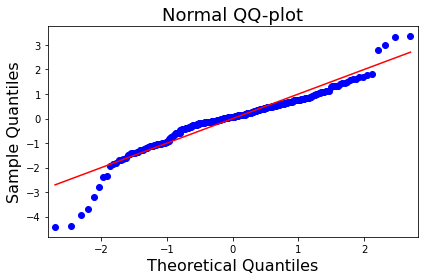

In [50]:
# residuals (QQ Plot)
res = model.resid
plt.figure(figsize = (10, 10))
fig = sm.qqplot(res, line='s', fit = True)
plt.xlabel('Theoretical Quantiles', fontsize = 16)
plt.ylabel('Sample Quantiles', fontsize = 16)
plt.title('Normal QQ-plot', fontsize = 18)
plt.tight_layout()
plt.show()
fig.savefig('finetuning_time_qqplot.png')

#### Random Forest

In [51]:
# Encode model names 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(np.unique(data3.model_name_or_path))
LabelEncoder()
list(le.classes_)
data3['model_encoded'] = le.transform(data3.model_name_or_path)

# print unique values of encoded model variable
np.unique(data3.model_encoded)

<ipython-input-51-30a4e8f3ad0a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['model_encoded'] = le.transform(data3.model_name_or_path)


array([0, 1, 2, 3, 4, 5, 6])

In [52]:
# Encode task names

lenc = LabelEncoder()
lenc.fit(np.unique(data3.task_name))
LabelEncoder()
list(lenc.classes_)
data3['task_encoded'] = lenc.transform(data3.task_name)

# print unique values of encoded model variable
np.unique(data3.task_encoded)

<ipython-input-52-712906d2410e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['task_encoded'] = lenc.transform(data3.task_name)


array([0, 1, 2, 3, 4, 5])

In [55]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

X = data3[['task_encoded', 'max_seq_length', 'per_device_train_batch_size', 'model_encoded']]
y = data3[['finetuning_time_log']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators = 500)
regr.fit(X_train, np.ravel(y_train))
y_pred = regr.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2017959869885542
Mean Squared Error: 0.08746914359880092
Root Mean Squared Error: 0.29575182771844527


In [56]:
importances = regr.feature_importances_
print(importances)

[0.65583664 0.23278287 0.01502755 0.09635294]


Feature: 0, Score: 0.65584
Feature: 1, Score: 0.23278
Feature: 2, Score: 0.01503
Feature: 3, Score: 0.09635


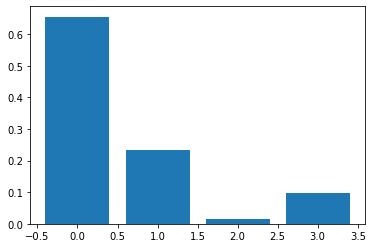

In [57]:
for i,v in enumerate(importances):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

# task_encoded, max_seq_length, per_device_train_batch_size, model_encoded

#### Relation between fine-tuning time and performance measures

In [58]:
np.unique(data.columns)

array(['Agent', 'Created', 'Name', 'Notes', 'Runtime', 'State', 'Sweep',
       'Tags', 'Training time', 'User', '__cached__setup_devices',
       'adam_epsilon', 'data_dir', 'dataloader_drop_last', 'debug',
       'do_eval', 'do_predict', 'do_train', 'epoch', 'eval_acc',
       'eval_acc_and_f1', 'eval_corr', 'eval_f1', 'eval_loss', 'eval_mcc',
       'eval_pearson', 'eval_spearmanr', 'eval_steps',
       'evaluate_during_training', 'finetuning_iters', 'finetuning_time',
       'finetuning_time_list', 'fp16', 'fp16_opt_level',
       'gradient_accumulation_steps', 'inference_time',
       'inference_time_list', 'learning_rate', 'local_rank',
       'logging_dir', 'logging_first_step', 'logging_steps', 'loss',
       'max_grad_norm', 'max_seq_length', 'max_steps',
       'model_name_or_path', 'no_cuda', 'num_train_epochs', 'output_dir',
       'overwrite_output_dir', 'past_index', 'per_device_eval_batch_size',
       'per_device_train_batch_size', 'per_gpu_train_batch_size',
       'sa

In [81]:
data3[['loss', 'eval_acc', 'eval_corr', 'eval_f1', 'eval_mcc',
       'eval_pearson', 'eval_spearmanr', 'task_name']].groupby("task_name").count()

# the majority of tasks incorporates the accuracy as performance measure 
# --> analysis of the relation between fine-tuning time and the accuracy is the main focus

,loss,eval_acc,eval_corr,eval_f1,eval_mcc,eval_pearson,eval_spearmanr
task_name,,,,,,,
CoLA,36,0,0,0,54,0,0
MRPC,51,51,0,51,0,0,0
RTE,63,63,0,0,0,0,0
SST-2,0,33,0,0,0,0,0
STS-B,30,0,45,0,0,45,45
WNLI,45,45,0,0,0,0,0


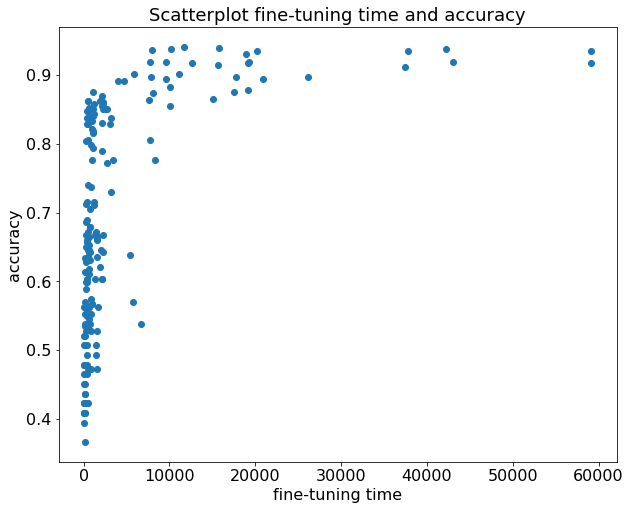

In [88]:
plt.figure(figsize = (10, 8))
scatter = plt.scatter(data3.finetuning_time, data3.eval_acc)
plt.ylabel('accuracy', fontsize = 16)
plt.xlabel('fine-tuning time', fontsize = 16)
plt.title('Scatterplot fine-tuning time and accuracy', fontsize = 18)
plt.show()
scatter.figure.savefig('scatter_finetuning_accuracy.png')

In [65]:
# delete all missing values of the accuracy to enable calculating the correlation

data4 = data3.dropna(subset=['eval_acc', 'finetuning_time'])
data4.shape[0]

192

#### Further exploration

In [66]:
np.corrcoef(data4.finetuning_time, data4.eval_acc)

array([[1.        , 0.51546416],
       [0.51546416, 1.        ]])

In [67]:
# linear regression model
acc, finetuning_4 = patsy.dmatrices('eval_acc ~ finetuning_time', data4)

# linear regression model
model_4 = linear_model.OLS(acc, finetuning_4).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               eval_acc   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     68.75
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           2.00e-14
Time:                        08:25:31   Log-Likelihood:                 105.73
No. Observations:                 192   AIC:                            -207.5
Df Residuals:                     190   BIC:                            -200.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6492      0.011     58.349      0.000       0.627       0.671
finetuning_time  9.152e-06    1.1e-06      8.292      0.000    6.97e-06    1.13e-05
==============================================================================
Omnibus:                       71.982   Durbin-Watson:                   0.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.977
Skew:                          -0.063   Prob(JB):                      0.00413
Kurtosis:                       1.836   Cond. No.                     1.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
data3.columns

Index(['State', 'task_name', 'model_name_or_path', 'learning_rate',
       'per_device_train_batch_size', 'max_seq_length', 'eval_steps',
       'eval_acc', 'eval_loss', 'eval_corr', 'eval_f1', 'eval_mcc',
       'eval_pearson', 'eval_spearmanr', 'finetuning_time_list',
       'finetuning_iters', 'loss', 'weight_decay', 'num_examples',
       'finetuning_time', 'tokens_per_batch', 'seq_len_cat', 'batch_size_cat',
       'finetuning_time_log', 'batch_size_log', 'seq_length_log',
       'model_encoded', 'task_encoded'],
      dtype='object')

In [69]:
data5 = data3.dropna(subset=['eval_f1', 'finetuning_time'])
data5.shape[0]

51

In [70]:
np.corrcoef(data5.finetuning_time, data5.eval_f1.astype('float64'))

array([[1.        , 0.04036483],
       [0.04036483, 1.        ]])

In [71]:
data6 = data3.dropna(subset=['eval_mcc', 'finetuning_time'])
data6.shape[0]

54

In [72]:
np.corrcoef(data6.finetuning_time, data6.eval_mcc.astype('float64'))

array([[1.       , 0.2163285],
       [0.2163285, 1.       ]])

In [73]:
data7 = data3.dropna(subset=['eval_corr', 'finetuning_time'])
data7.shape[0]

45

In [74]:
np.corrcoef(data7.finetuning_time, data7.eval_corr.astype('float64'))

array([[ 1.        , -0.25472292],
       [-0.25472292,  1.        ]])

In [75]:
data8 = data3.dropna(subset=['eval_pearson', 'finetuning_time'])
data8.shape[0]

45

In [76]:
np.corrcoef(data8.finetuning_time, data8.eval_pearson.astype('float64'))

array([[ 1.        , -0.24787451],
       [-0.24787451,  1.        ]])

In [77]:
data9 = data3.dropna(subset=['eval_spearmanr', 'finetuning_time'])
data9.shape[0]

45

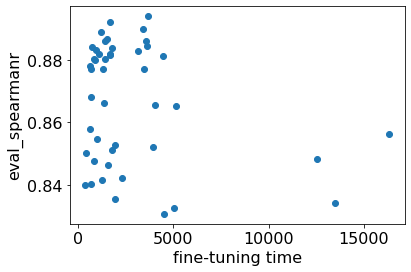

In [78]:
plt.scatter(data9.finetuning_time, data8.eval_spearmanr)
plt.ylabel('eval_spearmanr')
plt.xlabel('fine-tuning time')
plt.show()

In [79]:
# linear regression model
spearman, finetuning_9 = patsy.dmatrices('eval_spearmanr ~ finetuning_time', data9)

# linear regression model
model_9 = linear_model.OLS(spearman, finetuning_9).fit()
model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         eval_spearmanr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.135
Date:                Fri, 30 Oct 2020   Prob (F-statistic):             0.0837
Time:                        08:25:45   Log-Likelihood:                 115.78
No. Observations:                  45   AIC:                            -227.6
Df Residuals:                      43   BIC:                            -223.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8709      0.004    236.105      0.000       0.863       0.878
finetuning_time -1.499e-06   8.47e-07     -1.771      0.084   -3.21e-06    2.09e-07
==============================================================================
Omnibus:                       12.634   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                4.173
Skew:                          -0.426   Prob(JB):                        0.124
Kurtosis:                       1.776   Cond. No.                     5.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
np.corrcoef(data9.finetuning_time, data9.eval_spearmanr.astype('float64'))

array([[ 1.        , -0.26066475],
       [-0.26066475,  1.        ]])